# Final Exam - Open

## FINM 37400 - 2025

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

***

# Instructions

## Please note the following:

Points
* You have `100` minutes to complete the exam.
* For every minute late you submit the exam, you will lose one point.

Rules
* The exam is open-material, closed-communication.
* You do not need to cite material from the course github repo - you are welcome to use the code posted there without citation.

Advice
* If you find any question to be unclear, state your interpretation and proceed. We will only answer questions of interpretation if there is a typo, error, etc.
* The exam will be graded for partial credit.

## Data

**All data files are found in the class github repo, in the `data` folder.**

- For Section 1:
    * No data file is needed.
- for Section 2:
    * `data/treasury_quotes_clean_2024-12-31.xlsx`, sheet `selected quotes`.

## Scoring

| Problem | Points |
|---------|--------|
| 1       | 70     |
| 2       | 30     |

***

## Submitting your Exam

Submission
* You will upload your solution to the `Exam - Open` assignment on Canvas. 
* Submit a compressed, "zipped", folder containing all code according to the file structure below.
* Name your submitted, zipped, folder `exam-open-LASTNAME-FIRSTNAME.zip`.
* Be sure to **submit** on Canvas, not just **save** on Canvas.

Your submission should **include all code and data used in your analysis** in the following folder structure.
* We strongly prefer all submissions are structred this way, and it will improve grading accuracy for partial credit. 
* Still, if you're struggling to get this working in time, no worries; just structure as comfortable and submit **everything used** for your submission.

__Exam Submission Structure:__

```plaintext
exam-open-LASTNAME-FIRSTNAME.zip/
│── exam-open.ipynb
│── data/
│   ├── example_data.csv
│── modules/
│   ├── my_functions.py

### Validating your folder structure

The next cell tests that you have this folder structure implemented.

In [1]:
import sys
sys.path.insert(0, 'modules')
from treasury_cmds import *
from fixedinc import *
import warnings
import math

warnings.filterwarnings("ignore")  # Ignore all warnings

In [2]:
from pathlib import Path
import sys
import pandas as pd

# Get the directory of the notebook (assumes Jupyter Notebook is always used)
BASE_DIR = Path().resolve()

# Define paths for data and modules
DATA_DIR = BASE_DIR / "data"
MODULES_DIR = BASE_DIR / "modules"

# Check if expected directories exist
if not DATA_DIR.exists():
    print(f"Warning: Data directory '{DATA_DIR}' not found. Check your file structure.")

if not MODULES_DIR.exists():
    print(f"Warning: Modules directory '{MODULES_DIR}' not found. Check your file structure.")

# Ensure Python can import from the modules directory
if str(MODULES_DIR) not in sys.path:
    sys.path.append(str(MODULES_DIR))

# # Load exam data
# EXAMPLE_DATA_PATH = DATA_DIR / "treasury_quotes_clean_2024-12-31.xlsx"

# if EXAMPLE_DATA_PATH.exists():
#     example_data = pd.read_csv(EXAMPLE_DATA_PATH)
# else:
#     print(f"Warning: '{EXAMPLE_DATA_PATH.name}' not found. Ensure it's in the correct directory.")


***

# 1. The "Steepener" Trade

A popular trade in 2024 was the 2s10s "steepener" trade, which was a trade designed to capture the changes in the slope of yield curve while being hedged to parallel shifts in it. In particular, the trade believes that the 2-year treasury yield is too high relative to the 10-year treasury yield. We will replicate this trade.

`Initial date:` July 1st, 2024 (corresponding to $t=0$)

__2-year Bond:__
- `Time To Maturity:` 2 years
- `Coupon Frequency:` semi-annual
- `Coupon Rate:` 4%
- `Annualized semi-annual YTM:` 4.74%

__10-year Bond:__
- `Time To Maturity:` 10 years
- `Coupon Frequency:` semi-annual
- `Coupon Rate:` 2%
- `Annualized semi-annual YTM:` 4.44%

__Note__: Assume that coupons are paid exactly at the $t=0.5, 1, 1.5, ...$ year marks. 

In [3]:
bonds=[
    {"Bond":"2Y Treasury","Coupon":0.04,"YTM":0.0474,"TTM":2},
    {"Bond":"10Y Treasury","Coupon":0.02,"YTM":0.0444,"TTM":10}
]
summary_df_0 = pd.DataFrame(bonds).set_index("Bond")
summary_df_0.T

Bond,2Y Treasury,10Y Treasury
Coupon,0.0400,0.0200
YTM,0.0474,0.0444
TTM,2.0000,10.0000


### 1.1. (5pts)
Based on the given information, report the dirty price of each bond as of $t=0$ assuming a face value of $100. Display your answer rounded to 4 decimal places.

In [4]:
def bond_price(t, T, c, y, freq=2, face=100):
    n = int(freq * (T - t))
    price = 0
    for i in range(1, n):
        price += face * (c / 2) / ((1 + (y / 2)) ** (2 * ((i / freq) - t)))
    price += face * (1 + (c / 2)) / ((1 + (y / 2)) ** (2 * (T - t)))
    return price

In [5]:
results = []
for b in bonds:
    p = bond_price(0, b["TTM"], b["Coupon"], b["YTM"])
    results.append({"Bond": b["Bond"], "Price": round(p, 4)})
price_0 = pd.DataFrame(results).set_index("Bond")
price_0.T

Bond,2Y Treasury,10Y Treasury
Price,98.6037,80.4684


### 1.2. (5pts)

Report the modified duration and modified-dollar-duration for each bond. Calculate these modified duration values with respect to changes in the quoted semi-annual YTM. Display your answer rounded to 4 decimal places.

In [6]:
def bond_duration(t, T, c, y, freq=2, face=100):
    n = int(freq * (T - t))
    price = 0
    weighted_sum = 0
    for i in range(1, n):
        t_i = i / freq - t
        CF = face * (c / 2)
        pv = CF / ((1 + y / 2) ** (2 * t_i))
        price += pv
        weighted_sum += t_i * pv
    t_i = T - t
    CF = face * (1 + c / 2)
    pv = CF / ((1 + y / 2) ** (2 * t_i))
    price += pv
    weighted_sum += t_i * pv
    macaulay_duration = weighted_sum / price
    modified_duration = macaulay_duration / (1 + y / 2)
    modified_dollar_duration = modified_duration * price
    return modified_duration, modified_dollar_duration

In [7]:
results = []
for b in bonds:
    mod_dur, mod_dol_dur = bond_duration(0, b["TTM"], b["Coupon"], b["YTM"])
    results.append({
        "Bond": b["Bond"],
        "Modified Duration": round(mod_dur, 4),
        "Modified-Dollar Duration": round(mod_dol_dur, 4)
    })
duration_df = pd.DataFrame(results).set_index("Bond")
duration_df

,Modified Duration,Modified-Dollar Duration
Bond,,
2Y Treasury,1.8965,187.0042
10Y Treasury,8.7875,707.1151


### 1.3. (15pts)
We want to construct our portfolio in a modified-dollar-duration neutral fashion such that we are well hedged to parallel moves in the yield curve. 

Using the results from `1.2`, construct a portfolio aligned with the trade thesis that the YTM spread will converge, and go long one bond and short the other. 

Size the portfolio.
* Your position has a $1,000 (modified duration) exposure to a symmetric 1 basis-point convergence in the YTM spread.
* Assume the spread converges evenly, with 0.5bp convergence on each side.
* We assume no leverage is used. 

Report your position in each bond as:
* the notional amount.
* the market value.
* the number of bond contracts (assuming each contract has a face/par value of $100).

Display your answers rounded to the nearest integer.

In [22]:
data = {}
for b in bonds:
    p = bond_price(0, b["TTM"], b["Coupon"], b["YTM"])
    mod_dur, mod_dol = bond_duration(0, b["TTM"], b["Coupon"], b["YTM"])
    data[b["Bond"]] = {"Price": p, "Mod_Dol": mod_dol}
    
MD2 = data["2Y Treasury"]["Mod_Dol"]
MD10 = data["10Y Treasury"]["Mod_Dol"]
price2 = data["2Y Treasury"]["Price"]
price10 = data["10Y Treasury"]["Price"]

x = 1000 / (MD2 * 0.0001)
y = (MD2 / MD10) * x

pos = [
    {"Bond": "2Y Treasury Long", 
     "Notional": round(x), 
     "Market Value": round((x / 100) * price2), 
     "Contracts": round(x / 100)},
    {"Bond": "10Y Treasury Short", 
     "Notional": round(y), 
     "Market Value": round((y / 100) * price10), 
     "Contracts": round(y / 100)}
]

positions = pd.DataFrame(pos).set_index("Bond")
positions
# GPT Prompt: Cleanup the results from the code into a final df

,Notional,Market Value,Contracts
Bond,,,
2Y Treasury Long,52934,52613,529
10Y Treasury Short,13727,11342,137


### 1.4. (10pts)

Assume we are now at $t=0.05$, and the bond yields have now moved.

__2-year Bond:__
- `Annualized semi-annual YTM:` 4.32%

__10-year Bond:__
- `Annualized semi-annual YTM:` 4.14%

For each bond, report the new dirty price and clean price. Display your answer rounded to 4 decimal places.

In [9]:
def bond_dirty_clean_price(settlement, T, coupon, y, freq=2, face=100):
    coupon_period = 1 / freq
    cp = face * coupon / freq
    coupon_dates = [i * coupon_period for i in range(1, int(T * freq) + 1)]
    last_coupon = 0
    for d in coupon_dates:
        if d <= settlement:
            last_coupon = d
    accrued = cp * (settlement - last_coupon) / coupon_period
    dirty = 0
    for d in coupon_dates:
        if d > settlement:
            cf = cp
            if abs(d - T) < 1e-8:
                cf += face
            dirty += cf / ((1 + y / 2) ** (2 * (d - settlement)))
    clean = dirty - accrued
    return dirty, clean

In [10]:
settlement = 0.05
bonds = [
    {"Bond": "2Y Treasury", "Coupon": 0.04, "YTM": 0.0432, "TTM": 2},
    {"Bond": "10Y Treasury", "Coupon": 0.02, "YTM": 0.0414, "TTM": 10}
]
results = []
for b in bonds:
    dirty, clean = bond_dirty_clean_price(settlement, b["TTM"], b["Coupon"], b["YTM"])
    results.append({
        "Bond": b["Bond"],
        "Dirty Price": round(dirty, 4),
        "Clean Price": round(clean, 4)
    })
df = pd.DataFrame(results).set_index("Bond")
df

,Dirty Price,Clean Price
Bond,,
2Y Treasury,99.6058,99.4058
10Y Treasury,82.7910,82.6910


### 1.5. (10pts)

Still at $t=0.05$, report the profit-and-loss **(PnL)** of each position, and also for the entire portfolio, using:
* Duration (first-order YTM changes).

Use the $t=0$ modified-dollar-duration values from part `1.2`. 

Display your answer rounded to 4 decimal places.

In [23]:
bonds_init = [
    {"Bond": "2Y Treasury", "Coupon": 0.04, "YTM": 0.0474, "TTM": 2},
    {"Bond": "10Y Treasury", "Coupon": 0.02, "YTM": 0.0444, "TTM": 10}
]

metrics = {}

for b in bonds_init:
    mod_dur, mod_dol = bond_duration(0, b["TTM"], b["Coupon"], b["YTM"])
    metrics[b["Bond"]] = {"ModDol": mod_dol, "Price": bond_price(0, b["TTM"], b["Coupon"], b["YTM"])}
    
MDD2 = metrics["2Y Treasury"]["ModDol"]
MDD10 = metrics["10Y Treasury"]["ModDol"]

x = 1000 / (MDD2 * 0.0001)
y = (MDD2 / MDD10) * x
dy_2 = 0.0432 - 0.0474
dy_10 = 0.0414 - 0.0444
dP2 = -MDD2 * dy_2
dP10 = -MDD10 * dy_10
pnl_2 = (x / 100) * dP2
pnl_10 = - (y / 100) * dP10
pnl_total = pnl_2 + pnl_10
results = [
    {"Position": "2Y Treasury Long", "PnL": round(pnl_2, 4)},
    {"Position": "10Y Treasury Short", "PnL": round(pnl_10, 4)},
    {"Position": "Portfolio Total", "PnL": round(pnl_total, 4)}
]
df = pd.DataFrame(results).set_index("Position")
df
# GPT Prompt: Using the above functions, calculate the pnl for each position using dollar duration

,PnL
Position,
2Y Treasury Long,420.0
10Y Treasury Short,-300.0
Portfolio Total,120.0


### 1.6 (10pts)

Repeat `1.5`, but this time uapproximating the PnL using
* Duration + convexity

In [24]:
def bond_convexity(t, T, coupon, y, freq=2, face=100):
    n = int(freq*(T-t))
    price = 0
    convexity_sum = 0
    for i in range(1, n):
        t_i = i/freq - t
        CF = face * (coupon/2)
        disc = (1+y/2)**(2*t_i)
        price += CF/disc
        convexity_sum += CF * t_i * (t_i + 1/freq) / ((1+y/2)**(2*t_i+2))
    t_i = T - t
    CF = face * (1+coupon/2)
    disc = (1+y/2)**(2*t_i)
    price += CF/disc
    convexity_sum += CF * t_i * (t_i + 1/freq) / ((1+y/2)**(2*t_i+2))
    return convexity_sum/price, price
# GPT Prompt: Share code for bond convexity for coupon bond

In [25]:
metrics = {}
for b in bonds_init:
    P0 = bond_price(0, b["TTM"], b["Coupon"], b["YTM"])
    _, mod_dol = bond_duration(0, b["TTM"], b["Coupon"], b["YTM"])
    conv, _ = bond_convexity(0, b["TTM"], b["Coupon"], b["YTM"])
    metrics[b["Bond"]] = {"Price": P0, "ModDol": mod_dol, "Convexity": conv}
    
MDD2 = metrics["2Y Treasury"]["ModDol"]
MDD10 = metrics["10Y Treasury"]["ModDol"]
Price2 = metrics["2Y Treasury"]["Price"]
Price10 = metrics["10Y Treasury"]["Price"]
conv2 = metrics["2Y Treasury"]["Convexity"]
conv10 = metrics["10Y Treasury"]["Convexity"]

notional_2Y = 1000 / (MDD2 * 0.0001)
notional_10Y = (MDD2 / MDD10) * notional_2Y

dy_2 = 0.0432 - 0.0474
dy_10 = 0.0414 - 0.0444
dP2 = - MDD2 * dy_2 + 0.5 * (conv2 * Price2) * (dy_2**2)
dP10 = - MDD10 * dy_10 + 0.5 * (conv10 * Price10) * (dy_10**2)
pnl_2 = (notional_2Y/100) * dP2
pnl_10 = - (notional_10Y/100) * dP10
pnl_total = pnl_2 + pnl_10
results = [
    {"Position": "2Y Treasury Long", "PnL": round(pnl_2, 4)},
    {"Position": "10Y Treasury Short", "PnL": round(pnl_10, 4)},
    {"Position": "Portfolio Total", "PnL": round(pnl_total, 4)}
]
df = pd.DataFrame(results).set_index("Position")
df

,PnL
Position,
2Y Treasury Long,422.1325
10Y Treasury Short,-304.4590
Portfolio Total,117.6735


### 1.7. (5pts)

Repeat `1.5`, but this time calculating the PnL via
* full repricing (using your pricing results from part `1.4`.)

Display the comparison of the PnL across the three methods of `1.5`, `1.6`, and `1.7`.

In [14]:
metrics = {}
for b in bonds_init:
    P0 = bond_price(0, b["TTM"], b["Coupon"], b["YTM"])
    _, mod_dol = bond_duration(0, b["TTM"], b["Coupon"], b["YTM"])
    conv, _ = bond_convexity(0, b["TTM"], b["Coupon"], b["YTM"])
    metrics[b["Bond"]] = {"Price": P0, "ModDol": mod_dol, "Conv": conv, "Coupon": b["Coupon"], "TTM": b["TTM"], "YTM": b["YTM"]}
MDD2 = metrics["2Y Treasury"]["ModDol"]
MDD10 = metrics["10Y Treasury"]["ModDol"]
Price2 = metrics["2Y Treasury"]["Price"]
Price10 = metrics["10Y Treasury"]["Price"]
conv2 = metrics["2Y Treasury"]["Conv"]
conv10 = metrics["10Y Treasury"]["Conv"]
x = 1000 / (MDD2 * 0.0001)
y_notion = (MDD2 / MDD10) * x
dy_2 = 0.0432 - 0.0474
dy_10 = 0.0414 - 0.0444
dP2_duration = -MDD2 * dy_2
dP10_duration = -MDD10 * dy_10
pnl_2_duration = (x / 100) * dP2_duration
pnl_10_duration = - (y_notion / 100) * dP10_duration
total_duration = pnl_2_duration + pnl_10_duration
dP2_dc = -MDD2 * dy_2 + 0.5 * (conv2 * Price2) * (dy_2 ** 2)
dP10_dc = -MDD10 * dy_10 + 0.5 * (conv10 * Price10) * (dy_10 ** 2)
pnl_2_dc = (x / 100) * dP2_dc
pnl_10_dc = - (y_notion / 100) * dP10_dc
total_dc = pnl_2_dc + pnl_10_dc
dirty2_new, _ = bond_dirty_clean_price(0.05, metrics["2Y Treasury"]["TTM"], metrics["2Y Treasury"]["Coupon"], 0.0432)
dirty10_new, _ = bond_dirty_clean_price(0.05, metrics["10Y Treasury"]["TTM"], metrics["10Y Treasury"]["Coupon"], 0.0414)
accrual2 = (100 * (metrics["2Y Treasury"]["Coupon"] / 2)) * (0.05 / 0.5)
accrual10 = (100 * (metrics["10Y Treasury"]["Coupon"] / 2)) * (0.05 / 0.5)
full_change_2 = dirty2_new - (Price2 + accrual2)
full_change_10 = dirty10_new - (Price10 + accrual10)
pnl_2_full = (x / 100) * full_change_2
pnl_10_full = - (y_notion / 100) * full_change_10
total_full = pnl_2_full + pnl_10_full
data = [
    {"Position": "2Y Treasury Long",
     "Duration PnL": round(pnl_2_duration, 4),
     "Duration+Convexity PnL": round(pnl_2_dc, 4),
     "Full Repricing PnL": round(pnl_2_full, 4)},
    {"Position": "10Y Treasury Short",
     "Duration PnL": round(pnl_10_duration, 4),
     "Duration+Convexity PnL": round(pnl_10_dc, 4),
     "Full Repricing PnL": round(pnl_10_full, 4)},
    {"Position": "Portfolio Total",
     "Duration PnL": round(total_duration, 4),
     "Duration+Convexity PnL": round(total_dc, 4),
     "Full Repricing PnL": round(total_full, 4)}
]
df = pd.DataFrame(data).set_index("Position")
df

,Duration PnL,Duration+Convexity PnL,Full Repricing PnL
Position,,,
2Y Treasury Long,420.0,422.1325,428.8953
10Y Treasury Short,-300.0,-304.4590,-314.3287
Portfolio Total,120.0,117.6735,114.5666


### 1.8 (5 pts)

* What do the results from `1.6` capture that `1.5` does not, and why might this be important to consider?
* For any change in the YTM spread, do we expect the first order P/L estimate to always underestimate or overestimate the second order P/L estimate? Explain your reasoning.

- Duration-only captures linear (first-order) sensitivity, missing the curvature (convexity) effect.
- Duration+Convexity includes the non-linear response of bond prices to yield changes.
- When yields fall, convexity boosts price gains, duration-only underestimates the benefit.
- When yields rise, convexity dampens price losses, duration-only overstates the loss.

### 1.9 (5pts)

Name two things the results from `1.7` capture that `1.6` does not.

- Full repricing precisely incorporates coupon accruals and the exact timing of cash flows, which the convexity approximation abstracts away.
- It captures all higher-order effects beyond the convexity, providing an exact reflection of the bond’s price change under yield shifts.

***

# 2. Extracting Curves

Use the selected treasury quotes in the file, `treasury_quotes_clean_2024-12-31.xlsx`, using sheet `selected quotes`.

* Market quotes are provided for treasury securities expiring approximately every six months over the next `7` years.
* You are welcome to assume that they mature at exaclty six-year increments or to use the exact dates.
* Consider the `price` column to represent the dirty mid price.

In [15]:
import pandas as pd
import numpy as np

In [16]:
filepath = '../data/treasury_quotes_clean_2024-12-31.xlsx'
SHEET = 'selected quotes'
quotes = pd.read_excel(filepath,sheet_name=SHEET).set_index('KYTREASNO')
quotes.head()

,type,quote date,issue date,maturity date,ttm,accrual fraction,cpn rate,bid,ask,price,accrued int,dirty price,ytm
KYTREASNO,,,,,,,,,,,,,
208073,note,2024-12-31,2023-06-30,2025-06-30,0.495551,0,4.625,100.240638,100.250357,100.245498,0,100.245498,0.041613
208158,note,2024-12-31,2023-12-31,2025-12-31,0.999316,0,4.250,100.025370,100.044656,100.035013,0,100.035013,0.042172
208242,note,2024-12-31,2024-06-30,2026-06-30,1.494867,0,4.625,100.535515,100.566765,100.551140,0,100.551140,0.042566
208332,note,2024-12-31,2024-12-31,2026-12-31,1.998631,0,4.250,100.008215,100.016028,100.012122,0,100.012122,0.042469
207904,note,2024-12-31,2022-06-30,2027-06-30,2.494182,0,3.250,97.654701,97.685951,97.670326,0,97.670326,0.042520


### 2.1. (15pts)

Bootstrap the spot curve. 

For maturity `T=5`, report
* the discount factor
* the semiannually-compounded discount rate
* the continuously-compounded discount rate

Round your answers to four decimal places.

In [17]:
QUOTE_DATE = quotes['quote date'].iloc[0]
t_date = pd.to_datetime(QUOTE_DATE)

CF = pd.DataFrame(data=0, index=quotes.index, columns=quotes['maturity date'])

for i in quotes.index:
    coupon_dates = get_coupon_dates(t_date,pd.to_datetime(quotes.loc[i,'maturity date']))

    if coupon_dates is not None:
        CF.loc[i,coupon_dates] = quotes.loc[i,'cpn rate']/2

    CF.loc[i,quotes.loc[i,'maturity date']] += 100

CF = CF.resample('m',axis=1).sum()
CF.drop(columns=CF.columns[(CF==0).all()],inplace=True)
CF = CF.fillna(0).sort_index(axis=1)
display(CF)
CF.shape

maturity date,2025-06-30,2025-12-31,2026-06-30,2026-12-31,2027-06-30,2027-12-31,2028-06-30,2028-12-31,2029-06-30,2029-12-31,2030-06-30,2030-12-31,2031-06-30,2031-12-31
KYTREASNO,,,,,,,,,,,,,,
208073,102.3125,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.00
208158,2.1250,102.1250,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.00
208242,2.3125,2.3125,102.3125,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.00
208332,2.1250,2.1250,2.1250,102.1250,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.00
207904,1.6250,1.6250,1.6250,1.6250,101.6250,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.00
207989,1.9375,1.9375,1.9375,1.9375,1.9375,101.9375,0.0000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.00
208075,2.0000,2.0000,2.0000,2.0000,2.0000,2.0000,102.0000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.00
208160,1.8750,1.8750,1.8750,1.8750,1.8750,1.8750,1.8750,101.8750,0.0000,0.0000,0.000,0.000,0.000,0.00
208244,2.1250,2.1250,2.1250,2.1250,2.1250,2.1250,2.1250,2.1250,102.1250,0.0000,0.000,0.000,0.000,0.00


(14, 14)

,KYTREASNO,Discount Factor,rate,Continuous Rate
ttm,,,,
0.495551,208073,0.979797,0.041613,0.041186
0.999316,208158,0.959148,0.042178,0.041739
1.494867,208242,0.938960,0.042579,0.042133
1.998631,208332,0.919428,0.042475,0.042031
2.494182,207904,0.900366,0.042525,0.042080
2.997947,207989,0.880618,0.042859,0.042406
3.496235,208075,0.861087,0.043238,0.042777
4.000000,208160,0.841273,0.043680,0.043210
4.495551,208244,0.822506,0.043941,0.043465


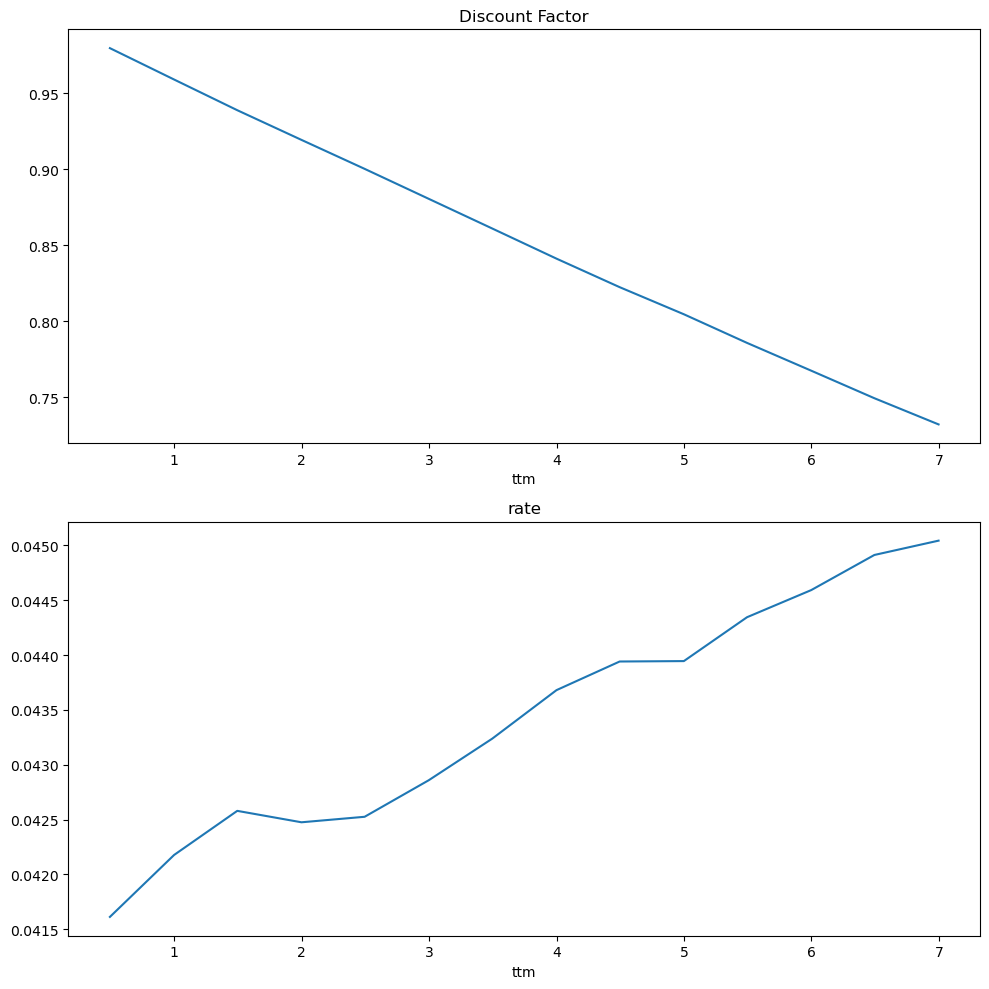

In [18]:
COMPOUNDING = 2
spot = pd.DataFrame(np.linalg.solve(CF,quotes['price'].loc[CF.index]), index=CF.index, columns=['Discount Factor'])
spot.insert(0,'ttm',quotes['ttm'])
spot = spot.reset_index().set_index('ttm')
spot['rate'] = discount_to_intrate(spot['Discount Factor'], spot.index,n_compound=COMPOUNDING)
spot["Continuous Rate"] = -np.log(spot["Discount Factor"]) /spot.index.astype(float)
display(spot)
fig, ax = plt.subplots(2,1,figsize=(10,10))
spot['Discount Factor'].plot(ax=ax[0],title='Discount Factor')
spot['rate'].plot(ax=ax[1],title='rate')
plt.tight_layout()
plt.show()

For maturity `T=5`, report
* the discount factor = 0.804677
* the semiannually-compounded discount rate = 0.043945
* the continuously-compounded discount rate = 0.043469

### 2.2. (10pts)

Use the bootstrapped spot curves to calculate the forward curves.

For maturity $T_1=5 \rightarrow T_2=5.5$, report
* the forward discount factor.
* the semiannually-compounded forward rate.
* the continuously-compounded forward rate.

Round your answers to four decimal places.

,Forward DF,Semiannual Rate,Continuous Rate
Maturity,,,
0.999316,0.9789,0.0427,0.0423
1.494867,0.9790,0.0434,0.0429
1.998631,0.9792,0.0422,0.0417
2.494182,0.9793,0.0427,0.0423
2.997947,0.9781,0.0445,0.0440
3.496235,0.9778,0.0455,0.0450
4.000000,0.9770,0.0467,0.0462
4.495551,0.9777,0.0460,0.0455
4.999316,0.9783,0.0440,0.0435


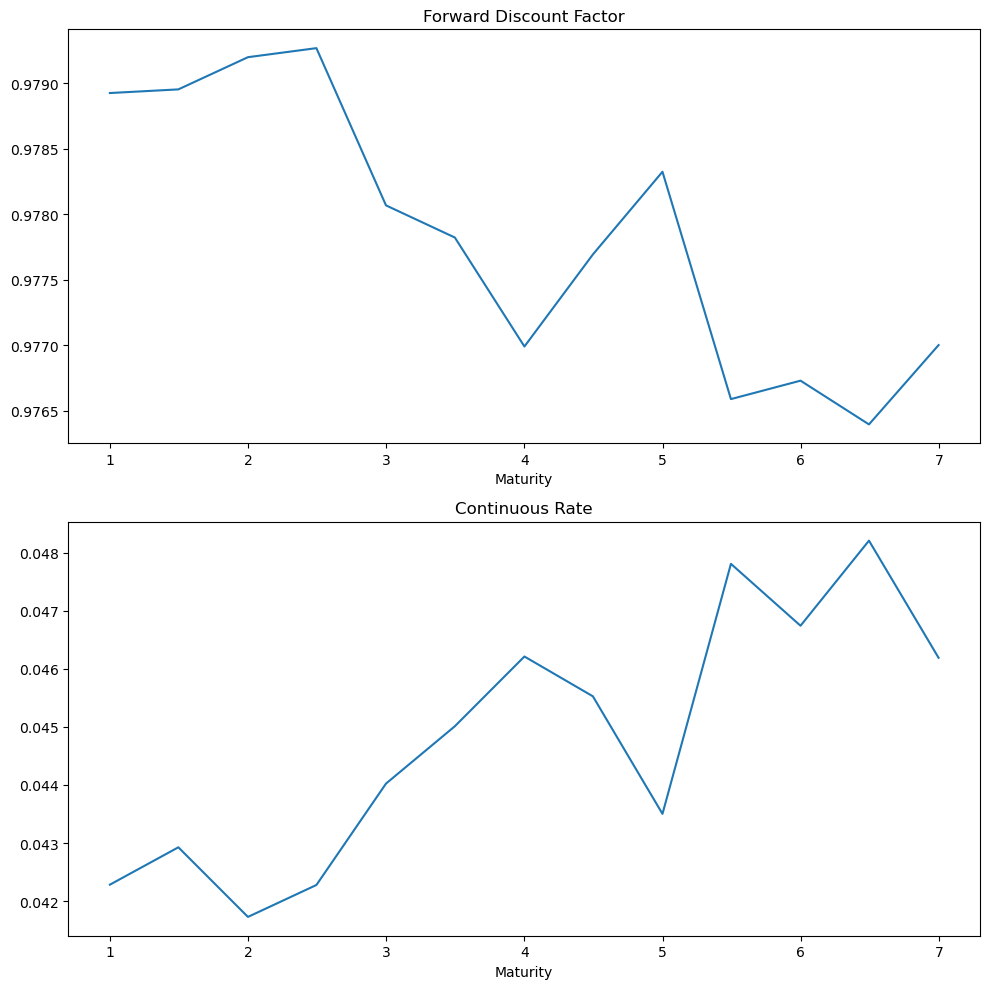

In [19]:
def forward_curve(maturities, df):
    rows = []
    for i in range(len(maturities)-1):
        T1 = maturities[i]
        T2 = maturities[i+1]
        f_df = df[i+1] / df[i]
        delta = T2 - T1
        sa_rate = 2 * ((1/f_df)**(1/(2*delta)) - 1)
        cont_rate = -math.log(f_df) / delta
        rows.append((T2, f_df, sa_rate, cont_rate))
    return pd.DataFrame(rows, columns=["Maturity", "Forward DF", "Semiannual Rate", "Continuous Rate"])

fc = forward_curve(list(spot.index), list(spot["Discount Factor"])).set_index("Maturity")
display(fc.round(4))

fig, ax = plt.subplots(2,1,figsize=(10,10))
fc['Forward DF'].plot(ax=ax[0],title='Forward Discount Factor')
fc['Continuous Rate'].plot(ax=ax[1],title='Continuous Rate')
plt.tight_layout()
plt.show()

For maturity $T_1=5 \rightarrow T_2=5.5$,
* the forward discount factor = 0.9783.
* the semiannually-compounded forward rate = 0.0440.
* the continuously-compounded forward rate = 0.0435. 

### 2.3. (5pts)

For which maturity ($T_1$ and $T_2$) is the forward rate highest?

In [20]:
max_cont = fc["Continuous Rate"].max()
max_cont_row = fc[fc["Continuous Rate"] == max_cont].iloc[0]
max_cont_row
print("T1 = 6.5, T2 = 7")

T1 = 6.5, T2 = 7


***